# Calculate Ridge Metrics

This notebook contains the code required to calculate ridge metrics from the previously created datasets:
- Ridges
- Migration Pathways
- Packets
- Ridge Area Raster
- DEM

From these datasets, we will calculate ridge width, amplitude, and migration distance at every ridge-transect intersection and aggregate/summarize these measurements at the intersection, ridge, transect, packet, and bend scales. 


In [8]:
from __future__ import annotations

from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio

from scrollstats import calculate_ridge_metrics

## Set input/output paths

In [9]:
# Vector Datasets
ridge_path = Path("example_data/output/LBR_025_ridges_manual_smoothed.geojson")
transect_path = Path("example_data/output/LBR_025_transects.geojson")
packet_path = Path("example_data/input/LBR_025_packets.geojson")
centerline_path = Path(
    "example_data/input/LBR_025_cl.geojson"
)  # only needed for plotting

# Raster Datasets
bin_clip_path = Path("example_data/output/LBR_025_dem_ridge_area_raster.tif")
dem_clip_path = Path("example_data/output/LBR_025_dem_clip.tif")

# Output
output_dir = Path("example_data/output")

## Read in datasets from input paths

In [10]:
# Vector Data
ridges = gpd.read_file(ridge_path)
transects = gpd.read_file(transect_path)
packets = gpd.read_file(packet_path)
cl = gpd.read_file(centerline_path)

# Raster Data
bin_raster = rasterio.open(bin_clip_path)
dem = rasterio.open(dem_clip_path)

## Calculate the ridge metrics

The `calculate_ridge_metrics` function takes the transects, ridges, clipped ridge area (binary) and DEM rasters as input and returns two GeoDataFrames
- `rich transects`
- `itx points`

The `rich_transects` retain the same geometry as the input transects but have the following additional fields:
- `r_000` ... `r_###`: the distance between the channel centerline and that ridge along the specified transect
- `dem_signal`: dem values sampled along the transect with 1m sampling 
- `bin_signal`: binary raster values sampled along the transect with 1m sampling
- `ridge_count_raster`: the ridge count along the transect calcualted from the number of unique ridges in `bin_signal`
- `fft_spacing`: the fft-derived dominant wavelength from `bin_signal` - corresponds to a representative spacing between ridges along the transect

The `itx` points are the collection of point intersections between the ridges and transects. `itx` contains the  three following ridge metrics in it's attribute field:
- `pre_mig_dist`: the migration distance from the previous ridge. Also referred to as "ridge spacing"
- `ridge_width`: the width of the ridge derived from `bin_signal` measured in px
- `ridge_amp`: the amplitude of the ridge derived from `dem_signal` measured in units of the DEM

`itx` also contains the following fields:
- `start_distances`: the along-transect distance to the intersection point
- `transect_position`: vertex position of the intersection point along the transect
- `metric_confidence`: a simple metric derived from `bin_signal` describing the confidence in other ridge metrics.
- `relative_vertex_distances`: the relative along-transect distance of the substring that corresponds to the intersection. A relative vertex position of 0.5 is at the exact midpoint of the transect.
- `vertex_indices`: the indicies of the `dem_signal` or `binary_signal` of the transect that correspond to the location of the itx substring
- `dem_signal`: the section of the transect's `dem_signal` that corresponds to the itx substring
- `dem_signal_selection`: a subset of `dem_signal` if the intersection point is on the first ridge from the channel
- `bin_signal`: the section of the transect's `bin_signal` that corresponds to the itx substring
- `bool_mask`: `bin_signal` expressed as a boolean array
- `post_mig_dist`: the migration distance to the next ridge
- `pre_mig_time`: the difference in `deposit_year` between the intersected and previous ridge
- `post_mig_time`: the difference in `deposit_year` between the intersected and next ridge
- `pre_mig_rate`: `pre_mig_dist` / `pre_mig_time`
- `post_mig_rate`: `post_mig_dist` / `post_mig_time`
- `deposit_year`: `deposit_year` of the corresponding ridge
- `substring_geometry`: the `LineString` of the substring corresponding to the intersection
- `geometry`: the `Point` geometry of the intersection
- `swale_dq_adjustment`: values up to this index are removed from `dem_signal`, `bin_signal`, and `bool_mask` for calculations. This distance is preserved in the output for subsequent plotting and analysis



In [11]:
rich_transects, itx = calculate_ridge_metrics(transects, ridges, bin_raster, dem)
itx = itx.loc["LBR_025"]

Ridge Metrics: 100%|##########| 25/25 [00:01<00:00, 13.20it/s]


In [12]:
# Add packets
itx_w_packets = itx.sjoin(packets.drop("bend_id", axis=1))
itx_w_packets = itx_w_packets.reset_index().set_index(
    ["transect_id", "ridge_id", "packet_id"]
)
ridge_metrics_w_packets = itx_w_packets[["ridge_amp", "ridge_width", "pre_mig_dist"]]
ridge_metrics_w_packets.columns = ridge_metrics_w_packets.columns.rename("metrics")

In [13]:
itx_w_packets.head()

start_distances  transect_position  \
transect_id ridge_id packet_id                                       
t_006       r_005    p_01            352.338052                  6   
            r_006    p_02            264.895523                  5   
            r_014    p_04            208.188951                  4   
            r_015    p_04            163.459517                  3   
            r_016    p_04            144.559731                  2   

                                metric_confidence  \
transect_id ridge_id packet_id                      
t_006       r_005    p_01                       4   
            r_006    p_02                       4   
            r_014    p_04                       4   
            r_015    p_04                       4   
            r_016    p_04                       3   

                                                        relative_vertex_distances  \
transect_id ridge_id packet_id                                                      
t_006       r_005    p_01           [0.7783108813116268, 0.8958311877266798, 1.0]   
            r_006    p_02       [0.5851512950615709, 0.7783108813116268, 0.895...   
            r_014    p_04       [0.45988710318970755, 0.5851512950615709, 0.77...   
            r_015    p_04       [0.3610802745303279, 0.45988710318970755, 0.58...   
            r_016    p_04       [0.31933085525277044, 0.3610802745303279, 0.45...   

                                 vertex_indices  \
transect_id ridge_id packet_id                    
t_006       r_005    p_01       [353, 406, 453]   
            r_006    p_02       [265, 353, 406]   
            r_014    p_04       [208, 265, 353]   
            r_015    p_04       [164, 208, 265]   
            r_016    p_04       [145, 164, 208]   

                                                                       dem_signal  \
transect_id ridge_id packet_id                                                      
t_006       r_005    p_01       [67.36290740966797, 67.37455749511719, 67.3284...   
            r_006    p_02       [66.92418670654297, 66.95668029785156, 66.9513...   
            r_014    p_04       [67.77173614501953, 67.77913665771484, 67.7264...   
            r_015    p_04       [68.31321716308594, 68.2929458618164, 68.28655...   
            r_016    p_04       [68.7772216796875, 68.75959014892578, 68.75959...   

                                                             dem_signal_selection  \
transect_id ridge_id packet_id                                                      
t_006       r_005    p_01       [67.36290740966797, 67.37455749511719, 67.3284...   
            r_006    p_02       [66.92418670654297, 66.95668029785156, 66.9513...   
            r_014    p_04       [67.77173614501953, 67.77913665771484, 67.7264...   
            r_015    p_04       [68.31321716308594, 68.2929458618164, 68.28655...   
            r_016    p_04       [68.7772216796875, 68.75959014892578, 68.75959...   

                                                                       bin_signal  \
transect_id ridge_id packet_id                                                      
t_006       r_005    p_01       [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...   
            r_006    p_02       [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
            r_014    p_04       [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
            r_015    p_04       [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...   
            r_016    p_04       [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   

                                                                        bool_mask  \
transect_id ridge_id packet_id                                                      
t_006       r_005    p_01       [True, True, True, True, True, True, True, Tru...   
            r_006    p_02       [True, True, True, True, True, True, True, Tru...   
            r_014    p_04       [True, True, True, True, True, True, True, Tru...   
  

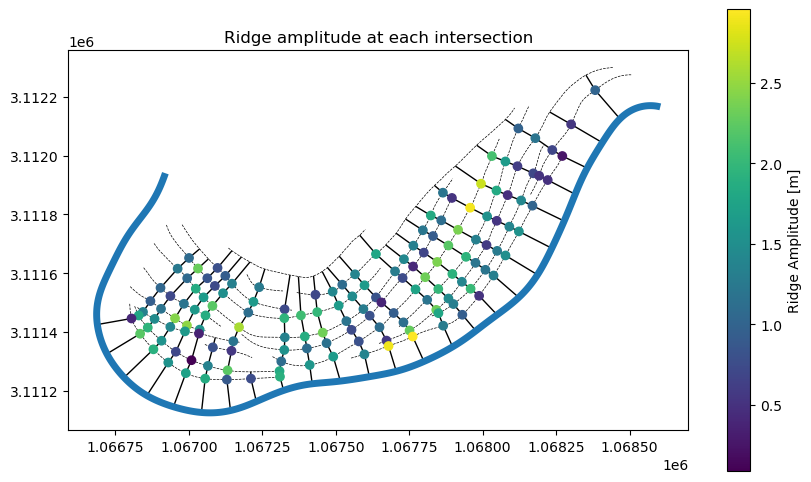

In [14]:
# Plot itx
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ridges.plot(ax=ax, color="k", ls="--", lw=0.5, zorder=0)
transects.plot(ax=ax, color="k", lw=1, zorder=1)
cl.plot(ax=ax, color="tab:blue", lw=5, zorder=2)

itx_w_packets.plot(
    column="ridge_amp",
    ax=ax,
    zorder=2,
    legend=True,
    legend_kwds={"label": "Ridge Amplitude [m]"},
)

ax.set_title("Ridge amplitude at each intersection");